<a href="https://colab.research.google.com/github/alecbidaran/Simple-deep-learning-projects/blob/main/Lstmexample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"


In [ ]:
print(tf.__version__)

2.2.0-rc3


In [ ]:
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


In [ ]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

<h1> create time series</h1>

In [ ]:
n_steps = 50
series = generate_time_series(10000, n_steps + 10)
series.shape

(10000, 60, 1)

In [ ]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

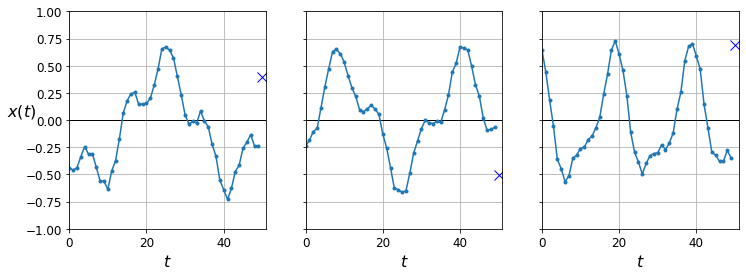

In [ ]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))

plt.show()

In [ ]:
X_train.shape,Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)
model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])


model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, None, 20)          1760      
_________________________________________________________________
lstm_9 (LSTM)                (None, None, 20)          3280      
_________________________________________________________________
time_distributed_7 (TimeDist (None, None, 10)          210       
Total params: 5,250
Trainable params: 5,250
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])


In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train,Y_train, epochs=20,
                    validation_data=(X_valid,Y_valid))

Epoch 1/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0760 - last_time_step_mse: 0.0615 - val_loss: 0.0553 - val_last_time_step_mse: 0.0364
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0480 - last_time_step_mse: 0.0283 - val_loss: 0.0427 - val_last_time_step_mse: 0.0222
Epoch 3/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0391 - last_time_step_mse: 0.0181 - val_loss: 0.0367 - val_last_time_step_mse: 0.0157
Epoch 4/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0350 - last_time_step_mse: 0.0151 - val_loss: 0.0334 - val_last_time_step_mse: 0.0132
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0325 - last_time_step_mse: 0.0133 - val_loss: 0.0313 - val_last_time_step_mse: 0.0121
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0308 - last_time_step_mse: 0.0122 - val_loss: 0.0297 - val_last_time_step_mse: 0.0112
Epoch 7/20
219/219 [=======

In [ ]:
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

In [ ]:
Y_pred

array([[[ 0.49453014],
        [ 0.33548546],
        [ 0.19703609],
        [ 0.12541404],
        [ 0.12689869],
        [ 0.12819937],
        [ 0.14058973],
        [ 0.07906863],
        [-0.02524564],
        [-0.14643507]]], dtype=float32)

In [ ]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

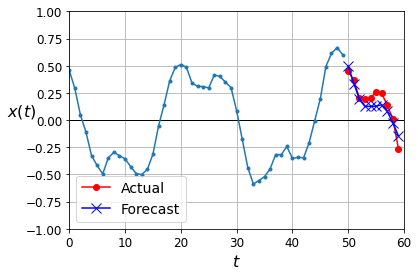

In [ ]:
plot_multiple_forecasts(X_new,Y_new,Y_pred)

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model1 = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model1.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model1.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0738 - last_time_step_mse: 0.0655 - val_loss: 0.0538 - val_last_time_step_mse: 0.0450
Epoch 2/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0476 - last_time_step_mse: 0.0367 - val_loss: 0.0441 - val_last_time_step_mse: 0.0326
Epoch 3/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0417 - last_time_step_mse: 0.0301 - val_loss: 0.0390 - val_last_time_step_mse: 0.0275
Epoch 4/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0368 - last_time_step_mse: 0.0243 - val_loss: 0.0339 - val_last_time_step_mse: 0.0202
Epoch 5/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0326 - last_time_step_mse: 0.0180 - val_loss: 0.0312 - val_last_time_step_mse: 0.0164
Epoch 6/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0306 - last_time_step_mse: 0.0155 - val_loss: 0.0294 - val_last_time_step_mse: 0.0143
Epoch 7/20
219/219 [=======

In [ ]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred1 = model1.predict(X_new)[:, -1][..., np.newaxis]

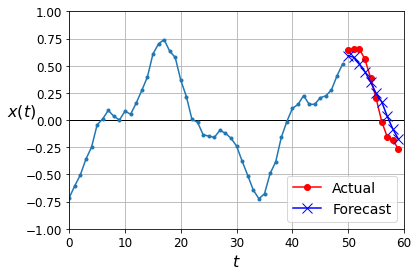

In [ ]:
plot_multiple_forecasts(X_new,Y_new,Y_pred1)

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model2 = keras.models.Sequential([
    keras.layers.Conv1D(filters=128, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, padding="same",
                        ),
    keras.layers.Conv1D(filters=128, kernel_size=2, strides=1, padding="same",
                        ),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model2.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model2.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Epoch 1/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0318 - last_time_step_mse: 0.0634 - val_loss: 0.0168 - val_last_time_step_mse: 0.0472
Epoch 2/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0142 - last_time_step_mse: 0.0393 - val_loss: 0.0118 - val_last_time_step_mse: 0.0333
Epoch 3/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0110 - last_time_step_mse: 0.0302 - val_loss: 0.0104 - val_last_time_step_mse: 0.0287
Epoch 4/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0099 - last_time_step_mse: 0.0264 - val_loss: 0.0092 - val_last_time_step_mse: 0.0250
Epoch 5/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0091 - last_time_step_mse: 0.0234 - val_loss: 0.0087 - val_last_time_step_mse: 0.0225
Epoch 6/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0086 - last_time_step_mse: 0.0211 - val_loss: 0.0084 - val_last_time_step_mse: 0.0200
Epoch 7/20
219/219 [=======

In [ ]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred2 = model2.predict(X_new)[:, -1][..., np.newaxis]

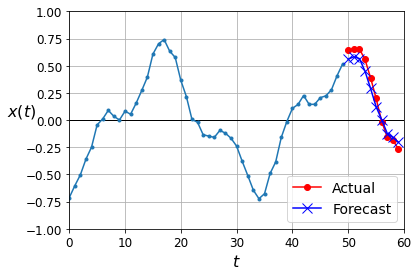

In [ ]:
plot_multiple_forecasts(X_new,Y_new,Y_pred2)